In [206]:
'''
---------------------------------------------------------------------
LSTM Training
Version: V1.6
Modified: 31.10.2024
William Siegle
---------------------------------------------------------------------
notebook can be converted to python script using: 
(python -m) jupytext --to py FILENAME.ipynb
---------------------------------------------------------------------
'''

global IS_NOTEBOOK
IS_NOTEBOOK = False
try:    # if running in IPython
    shell = get_ipython().__class__.__name__ # type: ignore 
    #%reset -f -s
    %matplotlib inline
    from IPython.display import display, HTML, Javascript
    from IPython.core.magic import register_cell_magic
    from IPython.display import clear_output
    @register_cell_magic    # cells can be skipped by using '%%skip' in the first line
    def skip(line, cell): return
    from tqdm.notebook import tqdm # type: ignore
    IS_NOTEBOOK = True
except (NameError, ImportError):    # if running in script
    from tqdm import tqdm
    from tabulate import tabulate
    print(f"{'-'*60}\nRunning in script mode")

In [207]:
# IMPORTS ---------------------------------------------------------------------
import sys
import os
import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from copy import deepcopy
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#from torchinfo import summary
#import pickle
#import random
#from scipy.signal import savgol_filter

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
from torch.nn.utils.rnn import pack_sequence
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torchmetrics.functional import mean_squared_error
torch.set_default_dtype(torch.float32)
torch.manual_seed(2);

# METRICS ---------------------------------------------------------------------
from sklearn.metrics import root_mean_squared_error
from torchmetrics.functional import mean_squared_error
from darts.metrics import mase

from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing import Pipeline

___
LOCATE DEVICES & SYSTEM FOLDERS

In [208]:
# DEVICE SELECTION ---------------------------------------------------------------------
global DEVICE
print(f"{'-'*60}\nTorch version: ", torch.__version__)
print('Cuda available: ',torch.cuda.is_available())
if torch.cuda.is_available():
    DEVICE = torch.device(f"cuda") 
    #DEVICE = torch.device("cuda:1")   # or overwrite with explicit Core number
    print(f'Currently Selected Device: {torch.cuda.current_device()}')
else:
    DEVICE = ("cpu")
print(f"   --> Using {DEVICE} device")

------------------------------------------------------------
Torch version:  2.4.1+cu121
Cuda available:  True
Currently Selected Device: 0
   --> Using cuda device


In [209]:
# ------------ LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  --------------
global ROOT, DATA_PATH
ROOT = Path('../..').resolve() if IS_NOTEBOOK else Path('.').resolve()
print(f"{'-'*60}\n{ROOT}:\t{', '.join([_.name for _ in ROOT.glob('*/')])}")
sys.path.append(os.path.abspath(ROOT))
from data import get_data_path  # paths set in "data/__init__.py"
DATA_PATH = get_data_path()
print(f"{DATA_PATH}:\t\t{', '.join([_.name for _ in DATA_PATH.glob('*/')])}")
# ----------------------------------------------------------------------------------------

------------------------------------------------------------
/home/sieglew/MA-eR-PINN:	project, ref, test, data, src, .git, archive
/home/sieglew/MA-Data:		__pycache__, trips_processed_resampled, final, y_true, processed, trips_processed_pickles, final_2, trips_processed_final


In [210]:
# FILE SOURCES ---------------------------------------------------------------
input_folder = Path(DATA_PATH, "final_2", "trips_processed_resampled") # Trip parquet files
pth_folder = Path(ROOT, "src", "models", "pth")
print(f"{'-'*60}\nInput Data: {input_folder}\nStore model in: {pth_folder}")

------------------------------------------------------------
Input Data: /home/sieglew/MA-Data/final_2/trips_processed_resampled
Store model in: /home/sieglew/MA-eR-PINN/src/models/pth


___
DATA PREPROCESSING

In [211]:
# PREPARE TRAIN & TEST SET ---------------------------------------------------
all_files = [Path(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".parquet")]
files = all_files
print(f"{'-'*60}\nTotal Files: {len(files)}\n{'-'*60}")
# ---------------------------------------------------
df = pd.read_parquet(Path(input_folder, random.choice(files)), engine='fastparquet')
all_signals = df.columns
assert len(all_signals) == 57

# get df stats:
# df.info()
'''from scipy.stats import shapiro
nd = []
for sig in df.columns:
    if np.ptp(df[sig]) != 0:
        _ , p = shapiro(df[sig])
        if p > 0.05:
            nd.append(sig)
print(f"{'-'*60}\nNormal Distributed Signals: {len(nd)}\n{'-'*60}")''';

------------------------------------------------------------
Total Files: 2975
------------------------------------------------------------


In [212]:
# INPUT & TARGET SPECIFICATION ---------------------------------------------------
# these signals are required for the physical Model calculation:
base_signals = ["signal_time", 
            "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "hv_batpwr_cval_bms1", "emot_pwr_cval",
            "bs_roadincln_cval", "roadgrad_cval_pt"]

# these signals have to be dropped in order for appropriate training:
columns_to_drop = ["hv_bat_soc_cval_bms1", "latitude_cval_ippc", "longitude_cval_ippc", "signal_time", "signal_ts"]

# ---------------------------------------------------
target_column = "hv_batmomavldischrgen_cval_1"
input_columns = all_signals.drop(columns_to_drop + [target_column])

In [213]:
# DATASET DEFINITION -----------------------------------------------------------------------
class TripDataset(Dataset):
    def __init__(self, file_list, scaler, target_scaler, fit=False):
        self.file_list = file_list
        self.scaler = scaler
        self.target_scaler = target_scaler
        self.fit = fit
        self.data = []
        self.targets = []

        if self.fit:
            print(f"fitting Scalers: {scaler.__class__.__name__}, {target_scaler.__class__.__name__}")
            # Initialize and Fit the scalers on the complete training data set
            # Fit the scalers incrementally to avoid memory errors
            for file in self.file_list:
                df = pd.read_parquet(file, engine='fastparquet')
                X = df[input_columns].values
                y = df[target_column].values.reshape(-1, 1)  # Reshape to match the shape of the input
                self.scaler.partial_fit(X)
                self.target_scaler.partial_fit(y)
            print(f"Done. Create DataSets...")

        for file in self.file_list:
            # DATA PREPROCESSING -----------------------------------------------------------
            # Assigning inputs and targets and reshaping ---------------
            df = pd.read_parquet(file, engine='fastparquet')
            X = df[input_columns].values
            y = df[target_column].values.reshape(-1, 1)  # Reshape to match the shape of the input
            # use the previously fitted scalers to transform the data
            X = self.scaler.transform(X)  
            y = self.target_scaler.transform(y).squeeze()
            # Append to data
            self.data.append(X)
            self.targets.append(y.squeeze())

    def __len__(self):
        return sum(len(target) for target in self.targets)

    def __getitem__(self, index):
        # Find which file the index belongs to
        # enables indexing over concatenated dataset via one timestep index
        for i, target in enumerate(self.targets):
            if index < len(target):
                return (
                    torch.tensor(self.data[i][index], dtype=torch.float32).unsqueeze(0),  # Add time dimension
                    torch.tensor(target[index], dtype=torch.float32)
                )
            index -= len(target)
        raise IndexError("Index out of range")

In [214]:
# FEATURE NORMALIZATION/SCALING -----------------------------------------------------------------
scaler = MaxAbsScaler() 
target_scaler = MinMaxScaler(feature_range=(0, 1))

# DATA SET SPLITTING -----------------------------------------------------------------------
# train_subset, test_subset = train_test_split(files, test_size=0.2, random_state=1)
train_subset, val_subset, test_subset = random_split(files, [0.8, 0.19, 0.01])

# SPECIFY BATCH SIZE  ---------------------------------------------------------------
batch_size = 512 # [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]

In [215]:
# GENERATE DATALOADERS  ---------------------------------------------------------------
# Note:
#   the scaler will be fitted only on the training data set
#   shuffling is prohibited to maintain the time series order

# TRAIN  ------------------------------------------------------------
train_dataset = TripDataset(train_subset, scaler, target_scaler, fit=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# VAL ------------------------------------------------------------
val_dataset = TripDataset(val_subset, scaler, target_scaler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# TEST ------------------------------------------------------------
test_dataset = TripDataset(test_subset, scaler, target_scaler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the size of the datasets
print(f"{'-'*60}\nTrain size:  {len(train_dataset)}\t\t(Files: {len(train_subset)})")
print(f'Val. size:   {len(val_dataset)}\t\t(Files: {len(val_subset)})')
print(f'Test size:   {len(test_dataset)}\t\t(Files: {len(test_subset)})')
if train_dataset.__len__() != sum(len(data) for data in train_dataset.data): print("Warning: Train Dataset Length Mismatch")

fitting Scalers: MaxAbsScaler, MinMaxScaler
Done. Create DataSets...
------------------------------------------------------------
Train size:  9838089		(Files: 2381)
Val. size:   2518884		(Files: 565)
Test size:   103709		(Files: 29)


In [216]:
subset_files = {
    "train": list(train_loader.dataset.file_list),
    "val": list(val_loader.dataset.file_list),
    "test": list(test_loader.dataset.file_list)}
print([os.path.basename(_) for _ in subset_files["train"][:3]])

['v_id983V13_trip163_2.parquet', 'v_id983V12_trip145_2.parquet', 'v_id983V2_trip48.parquet']


___
NETWORK ARCHITECTURE

In [217]:
# LSTM NETWORK -----------------------------------------------------------------------
class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, device = DEVICE): #, num_classes, seq_length):
        super(LSTM1, self).__init__()

        self.input_size = input_size    # input size
        self.hidden_size = hidden_size  # hidden state
        self.num_layers = num_layers    # number of layers
        #self.num_classes = num_classes  # number of classes
        #self.seq_length = seq_length    # sequence length

        # LSTM CELL --------------------------------
        self.lstm = nn.LSTM(
            self.input_size,            # The number of expected features in the input x
            self.hidden_size,           # The number of features in the hidden state h
            self.num_layers,            # Number of recurrent layers for stacked LSTMs. Default: 1
            batch_first = True,         # If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Default: False
            bias = True,                # If False, then the layer does not use bias weights b_ih and b_hh. Default: True
            dropout = 0.35,              # usually: [0.2 - 0.5] ,introduces a Dropout layer on the outputs of each LSTM layer except the last layer, (dropout probability). Default: 0
            bidirectional = False,      # If True, becomes a bidirectional LSTM. Default: False
            proj_size = 0,              # If > 0, will use LSTM with projections of corresponding size. Default: 0
            device = DEVICE) 
        
        # --------------------------------
        #self.fc_1 =  nn.Linear(hidden_size, 128)  # fully connected 1
        #self.fc = nn.Linear(128, num_classes)     # fully connected last layer
        # --------------------------------
        self.relu = nn.ReLU()
        self.fc_test =  nn.Linear(hidden_size, 1)

    
    def forward(self, input, batch_size = None):
        '''        
        # initial hidden and internal states
        # --------------------------------
        h_0 = torch.zeros(self.num_layers, input.size(0) if batch_size is None else batch_size, self.hidden_size)
        c_0 = torch.zeros(self.num_layers, input.size(0) if batch_size is None else batch_size, self.hidden_size)  
        # --------------------------------
        out = self.relu(hn.view(-1, self.hidden_size)) # reshaping the data for Dense layer next
        out = self.fc_1(out) # first Dense
        out = self.relu(out) # relu
        out = self.fc(out) # Final Output
        '''

        # Propagate input through LSTM
        # --------------------------------
        # output, (hn, cn) = self.lstm(input, (h_0, c_0)) # lstm with input, hidden, and internal state
        # input shape:      (batch_size, seq_length, input_size)
        # output shape:     (batch_size, seq_length, hidden_size)
        # --------------------------------
        out, _ = self.lstm(input)


        # ouput layers
        # --------------------------------
        out = self.relu(out) # relu
        out = self.fc_test(out[:, -1, :])  
        #out = self.fc_test(out)

        return out

In [218]:
# FCNN NETWORK -----------------------------------------------------------------------
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        
        # here, our linear layer will have an input of 200, not 100 as before:
        self.fc1 = nn.Linear(200,5)  
        self.fc2 = nn.Linear(5,10)   
        self.fc3 = nn.Linear(10,100) # but the output remains 100
        
          
    def forward(self, x):
        # we have to flatten our 20x2x100 to a 20x200:
        x = x.view(x.size(0),-1)     # x.size(0) is 20, and -1 is a shortcut for "figure out the other number for me please!"
        
        # the rest proceeds as before:
        x = F.relu(self.fc1(x))      
        x = F.relu(self.fc2(x))
        x = self.fc3(x)              
        return x
        
#net = FCNN()
#print(net) 

In [219]:
# MODEL CONFIGURATION -----------------------------------------------------------------------

# LAYERS --------------------------------
input_size = len(input_columns)     # expected features in the input x
hidden_size = 200                   # features in the hidden state h
num_layers = 2                      # recurrent layers for stacked LSTMs. Default: 1
num_classes = 1                     # output classes (=1 for regression)

# INSTANTIATE MODEL --------------------
model = LSTM1(input_size, hidden_size, num_layers).to(DEVICE)  #, num_classes, X_train_T_final.shape[1]
print(f"{'-'*60}\n",model)

------------------------------------------------------------
 LSTM1(
  (lstm): LSTM(51, 200, num_layers=2, batch_first=True, dropout=0.35)
  (relu): ReLU()
  (fc_test): Linear(in_features=200, out_features=1, bias=True)
)


___
TRAINING SETUP

In [220]:
# TRAINING CONFIGURATION -----------------------------------------------------------------------
global NUM_EPOCHS

# HYPERPARAMETERS ------------------------------------------------------------
NUM_EPOCHS = 10
learning_rate = 1e-2 # 0.001 lr

# OPTIMIZER -----------------------------
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate,
    weight_decay = 1e-4      # weight decay coefficient (default: 1e-2)
    #betas = (0.9, 0.95),    # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
    #eps = 1e-8,             # term added to the denominator to improve numerical stability (default: 1e-8)
)

# LOSS FUNCTION ----------------------------------------------------------------
def loss_fn(model_output, target):
    loss = F.mse_loss(model_output, target) # mean-squared error for regression
    return loss

# or define criterion function:
criterion = nn.MSELoss()
#criterion = nn.MSELoss(reduction='mean')

# ------------------------------------------------------------------------------
# print Model and Optimizer state_dicts
print(f"{'-'*60}\nModel state_dict:")
for param_tensor in model.state_dict(): print(f"{param_tensor}:\t {model.state_dict()[param_tensor].size()}")
print(f"{'-'*60}\n{optimizer}\n{'-'*60}\n{'-'*60}\n")

------------------------------------------------------------
Model state_dict:
lstm.weight_ih_l0:	 torch.Size([800, 51])
lstm.weight_hh_l0:	 torch.Size([800, 200])
lstm.bias_ih_l0:	 torch.Size([800])
lstm.bias_hh_l0:	 torch.Size([800])
lstm.weight_ih_l1:	 torch.Size([800, 200])
lstm.weight_hh_l1:	 torch.Size([800, 200])
lstm.bias_ih_l1:	 torch.Size([800])
lstm.bias_hh_l1:	 torch.Size([800])
fc_test.weight:	 torch.Size([1, 200])
fc_test.bias:	 torch.Size([1])
------------------------------------------------------------
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.0001
)
------------------------------------------------------------
------------------------------------------------------------



In [221]:
# Initialize a HTML table for performance tracking (if running in a notebook)
def initialize_table():
    table_html = """
    <table id="training_table" style="width:60%; border-collapse: collapse;">
        <thead style="position: sticky; top: 0; z-index: 1;">
            <tr>
                <th style="font-weight:bold; width:15%; text-align:left; padding: 10px; background-color: #404040;">Epoch</th>
                <th style="font-weight:bold; width:25%; text-align:left; padding: 10px; background-color: #404040;">Iteration</th>
                <th style="font-weight:bold; width:30%; text-align:left; padding: 10px; background-color: #404040;">Batch Loss</th>
                <th style="font-weight:bold; width:30%; text-align:left; padding: 10px; background-color: #404040;">Train Loss</th>
            </tr>
        </thead>
        <tbody>
        </tbody>
    </table>
    <script>
        function addRow(epoch, step, loss, running_loss) {
            var table = document.getElementById("training_table").getElementsByTagName('tbody')[0];
            var row = table.insertRow(-1);
            var cell1 = row.insertCell(0);
            var cell2 = row.insertCell(1);
            var cell3 = row.insertCell(2);
            var cell4 = row.insertCell(3);
            cell1.style.textAlign = "left";
            cell2.style.textAlign = "left";
            cell3.style.textAlign = "left";
            cell4.style.textAlign = "left";
            cell1.innerHTML = epoch;
            cell2.innerHTML = step;
            cell3.innerHTML = loss;
            cell4.innerHTML = running_loss;
            var scrollableDiv = document.getElementById("scrollable_table");
            scrollableDiv.scrollTop = scrollableDiv.scrollHeight;
        }
    </script>
    """
    return """<div id="scrollable_table" style="height: 300px; overflow-y: scroll;">""" + table_html + """</div>"""

# ---------------------------------------------------
def add_row(table, epoch, iteration, batch_loss, train_loss):
    table.append([epoch, iteration, batch_loss, train_loss])

# Function to print the performance table
header_printed = False
def print_row(training_table):
    global header_printed
    headers = ["Epoch", "Iteration", "Batch Loss", "Train Loss"]
    col_widths = [14, 14, 14, 14]  # Define fixed column widths

    def format_row(row):
        return [str(item).ljust(width) for item, width in zip(row, col_widths)]

    if not header_printed:
        formatted_headers = format_row(headers)
        tqdm.write(tabulate([training_table[-1]], headers=formatted_headers, tablefmt="plain", colalign=("left", "left", "left", "left")))
        header_printed = True
    else:
        formatted_row = format_row(training_table[-1])
        tqdm.write(tabulate([training_table[-1]], headers=format_row(["", "", "", ""]), tablefmt="plain", colalign=("left", "left", "left", "left")))

In [222]:
# TRAINING ROUTINE DEFINITION -----------------------------------------------------------------
def train_model(model, optimizer, loss_fn, train_loader, val_loader = None, state=None):
    def validate_model(model, val_loader, loss_fn):
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = loss_fn(outputs.squeeze(), targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)  # Calculate average validation loss
        return val_loss

    # output info on training process
    print(f"Training Started.\tProcess ID: {os.getpid()} \n{'-'*60}\n"
        f"Model: {model.__class__.__name__}\t\tParameters on device: {next(model.parameters()).device}\n{'-'*60}\n"
        f"Train/Batch size:\t{len(train_loader.dataset)} / {train_loader.batch_size}\n"
        f"Loss:\t\t\t{loss_fn}\nOptimizer:\t\t{optimizer.__class__.__name__}\nLR:\t\t\t"
        f"{optimizer.param_groups[0]['lr']}\nWeight Decay:\t\t{optimizer.param_groups[0]['weight_decay']}\n{'-'*60}")

    # Load state dict if provided
    start_epoch = 1
    if state:
        model.load_state_dict(state['model_state_dict'])
        optimizer.load_state_dict(state['optimizer_state_dict'])
        start_epoch = state['epoch'] + 1
        train_losses = state['train_losses']
        val_losses = state['val_losses']
        training_table = state['training_table']
    else:
        train_losses, val_losses, training_table = [], [], []  # collect loss
        if IS_NOTEBOOK: display(HTML(initialize_table()))

    # TRAINING LOOP:
    start_time = time.perf_counter()
    for epoch in range(start_epoch, NUM_EPOCHS + 1):
        model.train()   # set model to training mode
        running_loss = 0.0
        num_iterations = math.ceil(len(train_loader.dataset) / train_loader.batch_size)
        header_printed = False
        
        with tqdm(enumerate(train_loader, 1), unit="batch", total=num_iterations, leave=False) as tepoch:
            for iter, (inputs, targets) in tepoch:
                tepoch.set_description(f"Epoch {epoch}/{NUM_EPOCHS}")

                # -------------------------------------------------------------
                # Move data to the GPU
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)  
                # zero gradients -> forward pass -> obtain loss function -> apply backpropagation -> update weights:
                optimizer.zero_grad()
                outputs = model(inputs) 
                loss = loss_fn(outputs.squeeze(), targets) 
                loss.backward() 
                # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0) # optional: Gradient Value Clipping
                optimizer.step()

                # -------------------------------------------------------------
                # Update the performance table
                if iter % (num_iterations//4) == 0 and iter != num_iterations//4*4:
                    add_row(training_table, f" ", f"{iter}",f"{loss.item():.6f}", " ")
                    if IS_NOTEBOOK:
                        display(Javascript(f"""addRow("", "{iter}", "{loss.item():.6f}", "");"""))
                    else:
                        print_row(training_table)
                elif iter == 1:
                    add_row(training_table, f"{epoch}/{NUM_EPOCHS}", f"{iter}/{num_iterations}",f"{loss.item():.6f}", " ")
                    if IS_NOTEBOOK:
                        display(Javascript(f"""addRow("<b>{epoch}/{NUM_EPOCHS}", "{iter}/{num_iterations}", "{loss.item():.6f}", "");"""))
                    else:
                        print_row(training_table)
                        
                # -------------------------------------------------------------
                # Update running loss and progress bar
                running_loss += loss.item() # acculumate loss for epoch
                tepoch.set_postfix(loss=loss.item()); tepoch.update(1)

        # Calculate average training loss for the epoch
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Update the performance table
        add_row(training_table, f" ", f"{iter}",f"{loss.item():.6f}", f"{avg_train_loss:6f}")
        if IS_NOTEBOOK:
            display(Javascript(f"""addRow("", "{iter}", "{loss.item():.6f}", "<b>{avg_train_loss:.6f}");"""))
        else:
            print_row(training_table)

        # VALIDATION
        if val_loader:
            val_loss = validate_model(model, val_loader, loss_fn)
            val_losses.append(val_loss)
            # Update the performance table
            add_row(training_table, f" ", f"Validation Loss:",f"{val_loss:.6f}", f"")
            if IS_NOTEBOOK:
                display(Javascript(f"""addRow("<b>Val", "Validation Loss:", "<b>{val_loss:.4f}", "");"""))
            else:
                print_row(training_table)

    print(f"{'-'*60}\nTraining Completed.\tExecution Time: ", f"{(time.perf_counter() - start_time):.2f}", f"s\n")
    return {"train_losses": train_losses, "val_losses": val_losses, "epoch": epoch, "training_table": training_table, "model": model, 
    "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(),"loss_fn": loss_fn}

___
NETWORK TRAINING

In [223]:
# NETWORK TRAINING -----------------------------------------------------------------
resume = False
trained = train_model(
    model = model, 
    optimizer = optimizer, 
    loss_fn = criterion, 
    train_loader = train_loader,
    val_loader = val_loader)

Training Started.	Process ID: 1682706 
------------------------------------------------------------
Model: LSTM1		Parameters on device: cuda:0
------------------------------------------------------------
Train/Batch size:	9838089 / 512
Loss:			MSELoss()
Optimizer:		AdamW
LR:			0.01
Weight Decay:		0.0001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/19216 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [192]:
# SAVE MODEL  -----------------------------------------------------------------
# create unique model name
model_name = f'{model.__class__.__name__}_{datetime.now().strftime("%y%m%d_%H%M%S")}'
model_destination_path = Path(pth_folder, model_name + ".pth")

# add the splitted data subset information to save dict
trained['subset_files'] = subset_files
# save the model & print info
torch.save(trained, model_destination_path)
print(f"Model saved to:\t {model_destination_path}\nSize: {os.path.getsize(model_destination_path) / 1e6:.2f} MB")
if os.path.getsize(model_destination_path) > 100 * 1024**2:
    print("--> Warning: The saved model size exceeds 100MB!")

Model saved to:	 /home/sieglew/MA-eR-PINN/src/models/pth/LSTM1_241106_105031.pth
Size: 0.14 MB


In [193]:
# LOAD MODEL AT CHECKPOINT -----------------------------------------------------------------
# Select Model to Load:
#model_destination_path = Path(pth_folder, "LSTM_V1_6_hs256.pth")
# -----------------------------------------------------------------
checkpoint = torch.load(model_destination_path, weights_only=False)
for key in ["model", "loss_fn", "training_table", "train_losses", "val_losses", "epoch"]:
    globals()[key] = checkpoint[key]
# configure model and optimizer:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval(); # set model to evaluation mode for inference
print(f"Model loaded from:\t {model_destination_path}\n{'-'*60}")
print(f"Model: {model.__class__.__name__}\t\tParameters on device: {next(model.parameters()).device}\n{'-'*60}")
# get file list of test subset
test_files = checkpoint["subset_files"]["test"]

Model loaded from:	 /home/sieglew/MA-eR-PINN/src/models/pth/LSTM1_241106_105031.pth
------------------------------------------------------------
Model: LSTM1		Parameters on device: cuda:0
------------------------------------------------------------


In [118]:
# Move the model and its parameters to the CPU
model.to('cpu')
DEVICE = torch.device('cpu')

In [202]:
# RESUME TRAINING -----------------------------------------------------------------
resume = True
if resume: NUM_EPOCHS += 5 # train for 2 more epochs

trained = train_model(
    model = model, 
    optimizer = optimizer, 
    loss_fn = loss_fn, 
    train_loader = train_loader,
    val_loader = val_loader,
    state = checkpoint if resume else None)

Training Started.	Process ID: 1682706 
------------------------------------------------------------
Model: LSTM1		Parameters on device: cuda:0
------------------------------------------------------------
Train/Batch size:	1690699 / 1024
Loss:			MSELoss()
Optimizer:		AdamW
LR:			0.01
Weight Decay:		1e-05
------------------------------------------------------------


  0%|          | 0/1652 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/1652 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/1652 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/1652 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/1652 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------------
Training Completed.	Execution Time:  240.17 s



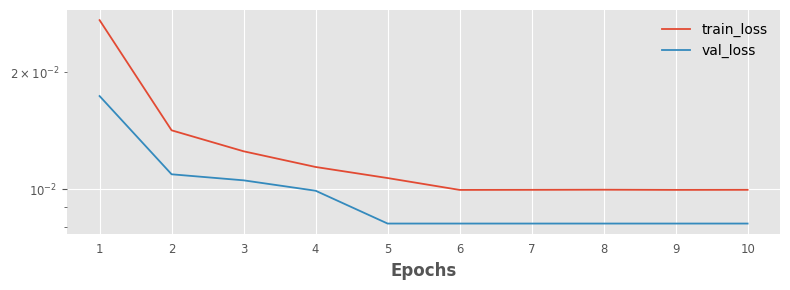

In [203]:
# get DataFrame of training metrics:
training_df = pd.DataFrame(training_table, columns=["Epoch", "Iteration", "Batch Loss", "Train Loss"])
# Extract the 'Train Loss' column and compare with the train_losses list
train_loss_column = training_df['Train Loss'].replace(['',' '], np.nan).dropna().astype(float).values
if any(abs(train_loss_column - train_losses) > 1e-3): 
    print("Extracted and original Train Losses are not equal. Please check metrics table.")

# -------------------------------------
# plot training performance:
fig, ax1 = plt.subplots(figsize=(8,3))
ax1.set_xlabel('Epochs')
ax1.set_xticks(range(1, NUM_EPOCHS + 1))

plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='train_loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='val_loss')
plt.style.use('ggplot'); plt.yscale('log'); fig.tight_layout(); plt.legend();

___
EVALUATION / POST-PROCESSING

In [195]:
# EVALUATION -----------------------------------------------------------------
model.eval() # set model to evaluation mode
test_loss = 0

with torch.no_grad():

    for iter, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)

        # Optional: Inverse-transform outputs and targets for evaluation
        # You can use `scaled_outputs` and `scaled_targets` for error metrics in the original scale if needed
        scaled_outputs = target_scaler.inverse_transform(outputs.detach().cpu().numpy().reshape(-1, 1))
        scaled_targets = target_scaler.inverse_transform(targets.detach().cpu().numpy().reshape(-1, 1))

        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss:  {test_loss:.4f}")
print(f"Iterations: {iter}/{math.floor(len(test_loader.dataset) / test_loader.batch_size)}")

Test Loss:  0.0059
Iterations: 41/41


RMSE: 85.6729


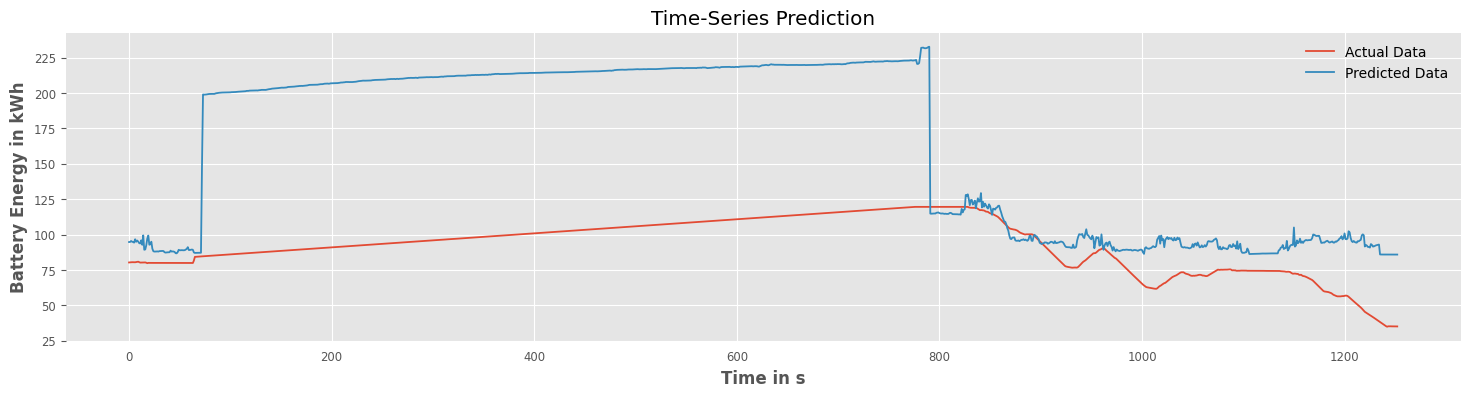

In [205]:
test_dataset = TripDataset(random.sample(test_files,1), scaler, target_scaler)
test_loader_2 = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
y_pred = []
with torch.no_grad():

    for iter, (inputs, targets) in enumerate(test_loader_2):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)
        y_pred.append(torch.mean(outputs).item())

y_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_true = target_scaler.inverse_transform(np.array(test_loader_2.dataset.targets[0] ).reshape(-1, 1))

###############################################
print(f"RMSE: {root_mean_squared_error(y_true, y_pred):.4f}")
plt.figure(figsize=(18,4)) 

plt.xlabel('Time in s')
plt.ylabel('Battery Energy in kWh')

plt.plot(y_true, label='Actual Data') # actual plot
plt.plot(np.arange(0, len(y_true), 1), y_pred, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend();

In [ ]:
model.eval()
with torch.no_grad():
    # Randomly select a sequence from the test dataset
    seq = random.randint(0, len(test_loader.dataset.data) - 1)

    # Get the inputs and targets for the selected sequence
    test_inputs = torch.tensor(test_loader.dataset.data[seq], dtype=torch.float32).unsqueeze(0).to(DEVICE).contiguous()
    test_targets = torch.tensor(test_loader.dataset.targets[seq], dtype=torch.float32).to(DEVICE).contiguous()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Perform inference
    outputs = model(test_inputs)
    inference_loss = criterion(outputs, test_targets)
    print(f"Inference Loss:  {inference_loss.item():.4f}")

    # Inverse-transform the outputs and targets for evaluation
    y_pred = target_scaler.inverse_transform(outputs.detach().cpu().numpy().reshape(-1, 1))
    y_true = target_scaler.inverse_transform(test_targets.detach().cpu().numpy().reshape(-1, 1))

    # Print the first few predictions and true values for comparison
    print("Predicted values:", y_pred[:5].flatten())
    print("True values:", y_true[:5].flatten())

Inference Loss:  0.0045
Predicted values: [110.16227]
True values: [116.15  116.147 116.1   116.052 116.012]


c:\Users\SIEGLEW\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([180])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
#%%skip
# PLOT RESULTS -----------------------------------------------------------------

# Reverse Transformation of the latest output and target
scaled_outputs = target_scaler.inverse_transform(outputs.detach().cpu().numpy().reshape(-1, 1))
scaled_targets = target_scaler.inverse_transform(targets.detach().cpu().numpy().reshape(-1, 1))

In [ ]:
y_true = target_scaler.inverse_transform(np.array(test_loader.dataset.targets[0] ).reshape(-1, 1))
y_true.shape

(405, 1)

In [ ]:
y_pred.shape

(1, 1)

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

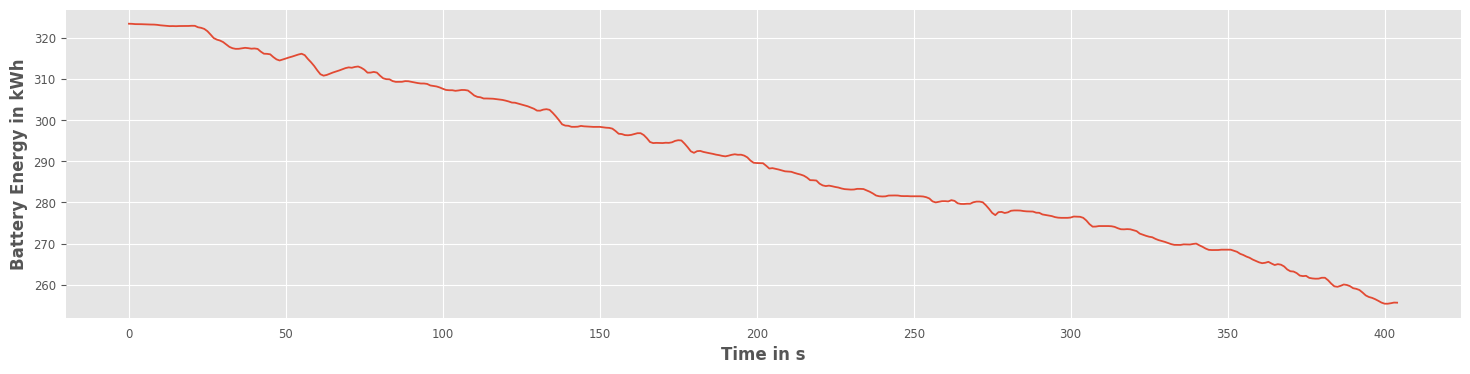

In [ ]:
from scipy.signal import savgol_filter

plt.figure(figsize=(18,4)) 

# Original and Smoothed plot
plt.xlabel('Time in s')
plt.ylabel('Battery Energy in kWh')
plt.plot(y_true, label='Actual Data') # actual plot
#plt.plot(np.arange(0, len(y_true), 10), y_pred, label='Predicted Data') # predicted plot

# Smoothed predicted plot
smoothed_y_pred = savgol_filter(y_pred.flatten(), window_length=100, polyorder=3)
plt.plot(np.arange(0, len(y_true), 10), smoothed_y_pred, label='Smoothed Predicted Data')

plt.title('Time-Series Prediction')
plt.legend()
plt.tight_layout()
plt.show()
